# Loan Challenge Report

*Yan Feng*

March 17th, 2019

## Loan challenge problem description

Banks are always seeking improved models to predict the loan. Data science and machine learning play an important role in this field. There are 2 data sets given to solve this problem. One is a table on the loan information containing 5 variables. The other is a table on the borrower information containing 12 variables.

The challenge is that based on the available information, 1. whether a loan should be granted; 2. if a loan is granted, whether the loan is repaid.

## Report Summary

1. The features of the raw data contain redundantnand unuseful information, and some features have NA values. The raw data was cleaned and the NA values were properly patched. There are 8 features selected for the latter model training. Some features are from original data, while others are newly formed based on the raw data.

2. The loan challenge was modeled into a multi-class classification problem. Two models, tree and random forest, were used to model the data set. 

3. To save time, 10% of the observations were used. When fitting the model, 75% of the data was used as training set, while 25% was used as testing set.

4. After model tuning, both models, tree and random forest, gave 73% - 74% accuracy for training and testing.

5. Among all selected features, yearly salary, saving amount, checking amount, and average use of the borrowers last year credit card limit are the 4 most important features. Whether the borrower is employed is contained in the feature of yearly salary with value of 0.

6. There are other information that can be used for fitting the model, for example, loan amount, debt to income ratio, original interest rate, current interest rate, loan term, etc.

7. Simpler tree model was used to develop a web application to predict whether loan is granted and whether granted loan is repaid. The application is deployed to shinyapps.io. [loan_challenge](https://boshishuoshuo.shinyapps.io/loan_challenge/)

8. The report is available in ipynb and pdf, and [online](  ).

9. The problem was solved with R 3.5.3, and the OS is Windows 10.

## Technical Details

### Outline

#### 1. Data import
#### 2. Data cleaning and feature extraction
#### 3. Model fitting and tuning
#### 4. Conclusions

#### 1. *Data import*

Download "loan_challenge.zip" file and put it in the working directory. Unzip the file and obtain 2 csv files in the working directory.

In [6]:
unzip("loan_challenge.zip")
unzip("loan_challenge/loan_challenge_data.zip")

Import the 2 csv files as data frames.

In [7]:
loan <- read.csv("loan_table.csv")
borrower <- read.csv("borrower_table.csv")

Quickly examine the 2 data frames.

In [9]:
str(loan)
str(borrower)

'data.frame':	101100 obs. of  5 variables:
 $ loan_id     : int  19454 496811 929493 580653 172419 77085 780070 303138 91475 422392 ...
 $ loan_purpose: Factor w/ 5 levels "business","emergency_funds",..: 4 4 5 5 1 5 1 2 4 1 ...
 $ date        : Factor w/ 260 levels "2012-01-02","2012-01-03",..: 54 12 29 128 101 175 53 175 105 214 ...
 $ loan_granted: int  0 0 0 1 1 0 1 1 1 0 ...
 $ loan_repaid : int  NA NA NA 1 0 NA 1 0 1 NA ...
'data.frame':	101100 obs. of  12 variables:
 $ loan_id                                        : int  289774 482590 135565 207797 828078 423171 568977 200139 991294 875332 ...
 $ is_first_loan                                  : int  1 0 1 0 0 1 1 1 0 0 ...
 $ fully_repaid_previous_loans                    : int  NA 1 NA 1 0 NA NA NA 1 1 ...
 $ currently_repaying_other_loans                 : int  NA 0 NA 0 0 NA NA NA 0 0 ...
 $ total_credit_card_limit                        : int  8000 4500 6900 1200 6900 6100 600 4000 7000 4300 ...
 $ avg_percentage_credit_car

"loan_id" is the common column between these 2 data frames, check whether they are identical.

In [10]:
all(sort(unique(loan$loan_id)) == sort(unique(borrower$loan_id)))

[1] TRUE

The 2 "loan_id" columns are identical to each other. Combine the 2 data frames into 1 data frame.

In [57]:
suppressWarnings(library(tidyverse))
loan_1 <- full_join(loan, borrower)

Joining, by = "loan_id"


Check the newly combined dataframe. It has 16 columns which is the combination of loan and borrower data frames.

In [13]:
dim(loan_1)

[1] 101100     16

Save the raw dataframe.

In [ ]:
save(loan_1, file = "loan_1.Rda")

#### 2. *Data cleaning and feature extraction*

Create a new variable "loan_status" that will combine loan_granted and loan_repaid. 0 means loan not granted, 1 means loan granted and repaid, -1 means loan granted but not repaid.

loan_status will be the response variable, and loan_granted and loan_repaid will be dropped.

In [14]:
loan_1 <- loan_1 %>% mutate(loan_status = ifelse(loan_granted == 0, 0, 
                                                   ifelse(loan_repaid == 1, 1, -1)))

loan_id is the identical number for a loan. It does not provide any useful information, so it will be dropped.

Check the loan_purpose variable, the proportion of loan_status varies among loan_purpose, so loan_purpose will be selected.

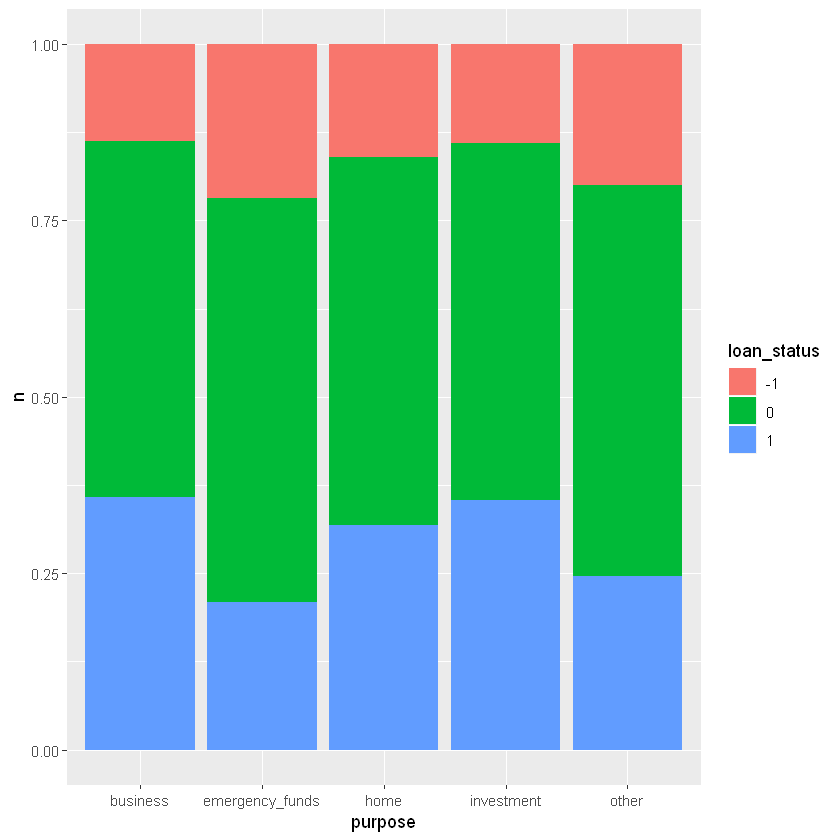

In [15]:
loan_1 %>% group_by(purpose = loan_purpose, loan_status) %>% count() %>% 
  ggplot(aes(x = purpose)) + geom_bar(aes(y = n, fill = as.factor(loan_status)), stat = "identity", position = "fill") +
  scale_fill_discrete(name = "loan_status")

Check the date variable. First convert date from factor to date using lubridate package. It turns out that all loans happened in the same year. Convert date to month and plot the proportion of loan_status. From the plot the variation is very small across all months. Date variable does not contain much information, so it will be dropped.

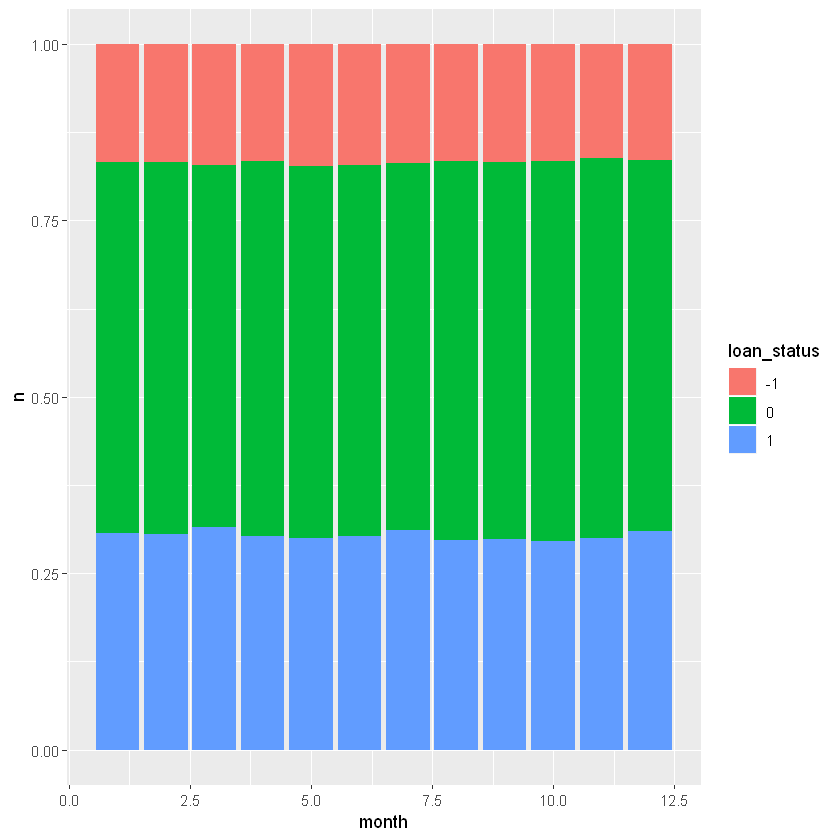

In [55]:
suppressWarnings(library(lubridate))
loan_1$date <- ymd(loan_1$date)
loan_1 %>% group_by(month = month(date), loan_status) %>% count() %>% 
  ggplot(aes(x = month)) + geom_bar(aes(y = n, fill = as.factor(loan_status)), stat = "identity",position = "fill") +
  scale_fill_discrete(name = "loan_status")

For the is_first_loan, fully_repaid_previous_loans, and currently_repaying_other_loans variables, the NA values in the latter 2 variables are the 1 values in the is_first_loan variable. 

So is_first_loan variable will be dropped, because its information is contained in the other 2 variables.

The NA values in fully_repaid_previous_loans and currently_repaying_other_loans variables will be assigned a value 2 to indicate it is the first_loan.

In [19]:
table(loan_1$is_first_loan)
table(loan_1$fully_repaid_previous_loans)
table(loan_1$currently_repaying_other_loans)
loan_1$fully_repaid_previous_loans[is.na(loan_1$fully_repaid_previous_loans)] <- 2
loan_1$fully_repaid_previous_loans <- factor(loan_1$fully_repaid_previous_loans,levels = c(0, 1, 2))
loan_1$currently_repaying_other_loans[is.na(loan_1$currently_repaying_other_loans)] <- 2
loan_1$currently_repaying_other_loans <- factor(loan_1$currently_repaying_other_loans, levels =  c(0, 1, 2))


    0     1 
46153 54947 


    0     1 
 4648 41505 


    0     1 
29338 16815 

For the fully_repaid_previous_loans variable, plot shows the proportions of loan_status among the 3 levels vary only a little. So it can not provide any useful information, it will be dropped.

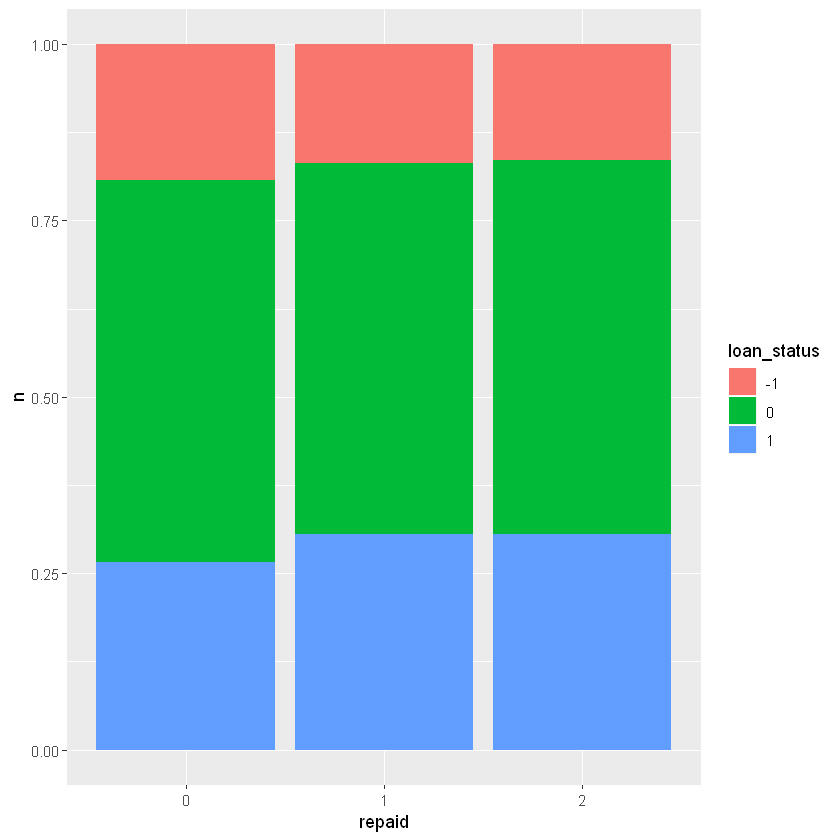

In [20]:
loan_1 %>% group_by(repaid = fully_repaid_previous_loans, loan_status) %>% count() %>% 
  ggplot(aes(x = repaid)) + geom_bar(aes(y = n, fill = as.factor(loan_status)), stat = "identity", position = "fill") +
  scale_fill_discrete(name = "loan_status")

However, currently_repaying_other_loans variable shows variations of proportions of loan_status, so it will stay.

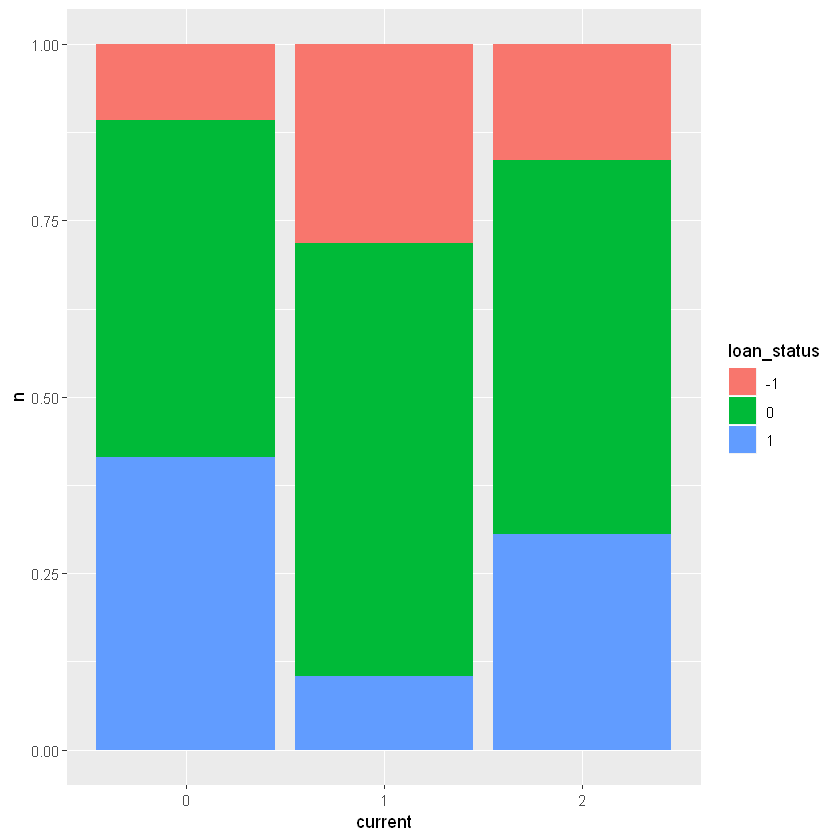

In [21]:
loan_1 %>% group_by(current = currently_repaying_other_loans, loan_status) %>% count() %>% 
  ggplot(aes(x = current)) + geom_bar(aes(y = n, fill = as.factor(loan_status)), stat = "identity", position = "fill") +
  scale_fill_discrete(name = "loan_status")

total_credit_card_limit was cut into 10 parts and to check whether it contributes to the variations of loan_status. From the plot, it clearly has a relationship with loan_status, so it will stay.

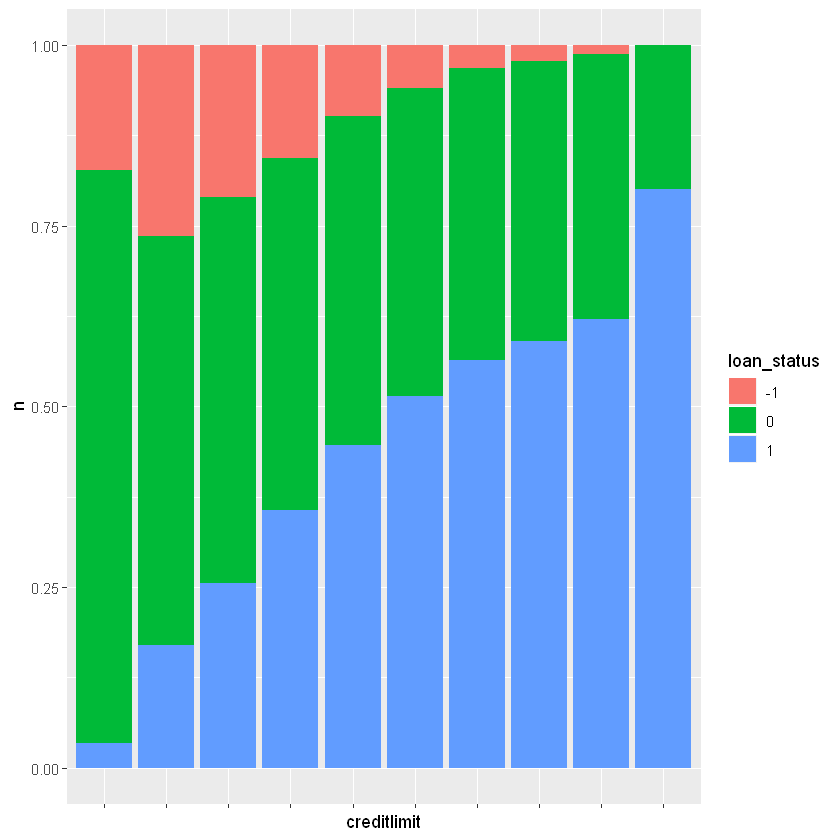

In [23]:
loan_1 %>% group_by(creditlimit = cut_interval(total_credit_card_limit, 10), loan_status) %>% 
  count() %>% ggplot(aes(x = creditlimit)) + 
  geom_bar(aes(y = n, fill = as.factor(loan_status)), stat = "identity", position = "fill") +
  scale_fill_discrete(name = "loan_status") + theme(axis.text.x = element_blank())

avg_percentage_credit_card_limit_used_last_year contains many NA values. The feature explanation does not indicate what NA stands for. So I need to decide whether NAs need to be patched or removed.

A plot for 2 groups of NA or not NA shows that if the avg_percentage_credit_card_limit_used_last_year variable is NA, a very large portion of loans was NOT granted. 

Then I check the range of avg_percentage_credit_card_limit_used_last_year, the largest value is 1.09. I assume NA strongly indicates the denial of the loan, NA is assumed to be a much larger value than 1.09.

I patched the NA with 2.

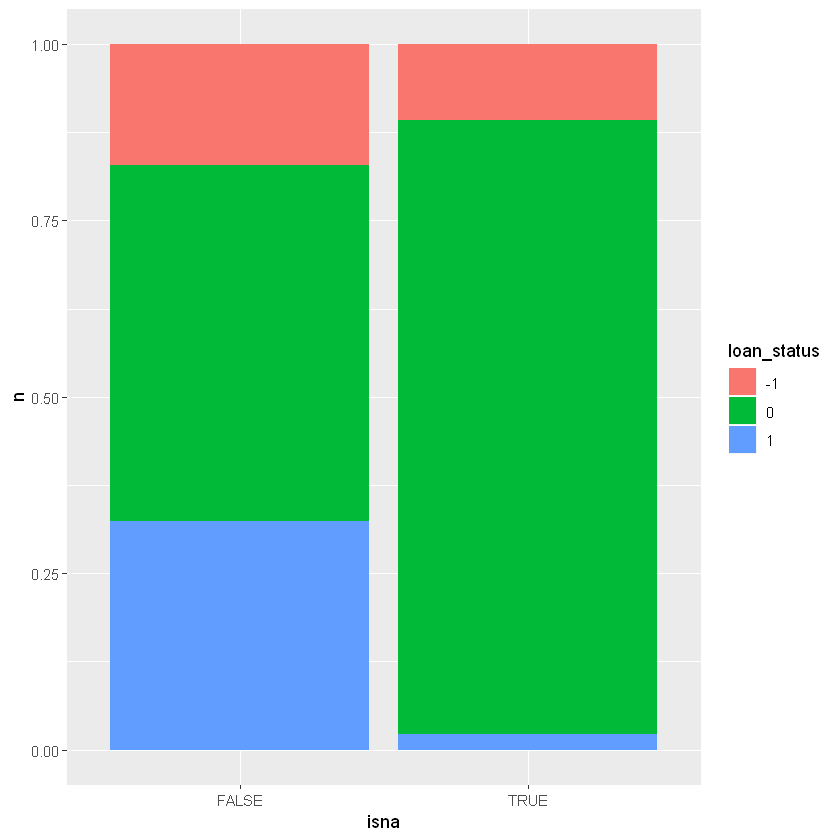

In [24]:
loan_1 %>% group_by(isna = is.na(avg_percentage_credit_card_limit_used_last_year), loan_status) %>% count() %>% 
  ggplot(aes(x = isna)) + geom_bar(aes(y = n, fill = as.factor(loan_status)), 
                                   stat = "identity", position = "fill") +
  scale_fill_discrete(name = "loan_status")
loan_1$avg_percentage_credit_card_limit_used_last_year[is.na(loan_1$avg_percentage_credit_card_limit_used_last_year)] <- 2

Plots of saving and checking amount cut into 10 parts show they should be taken into account.

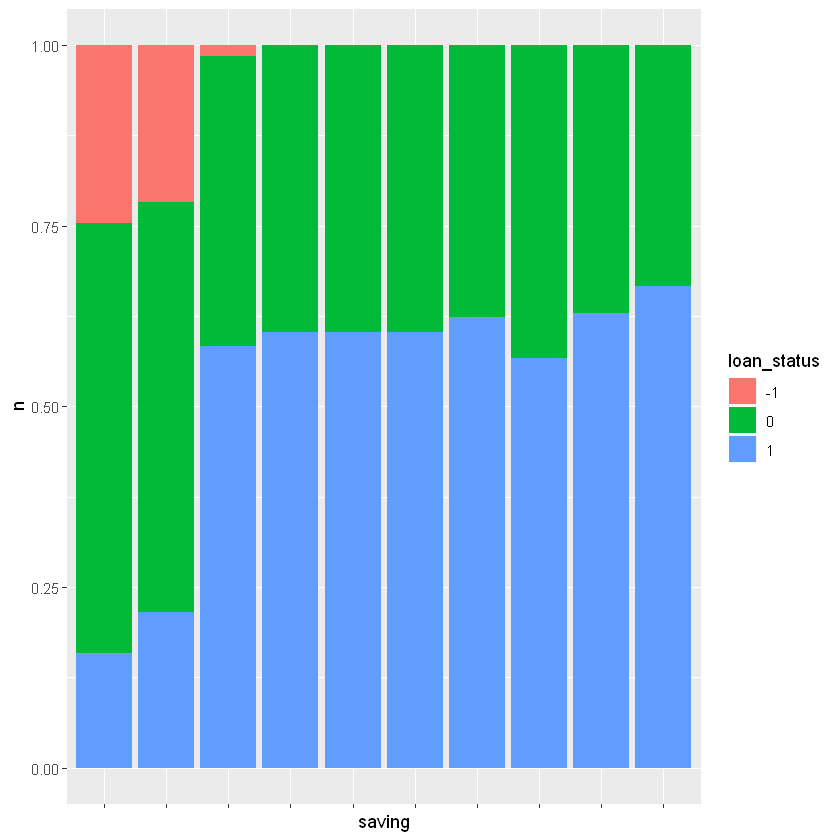

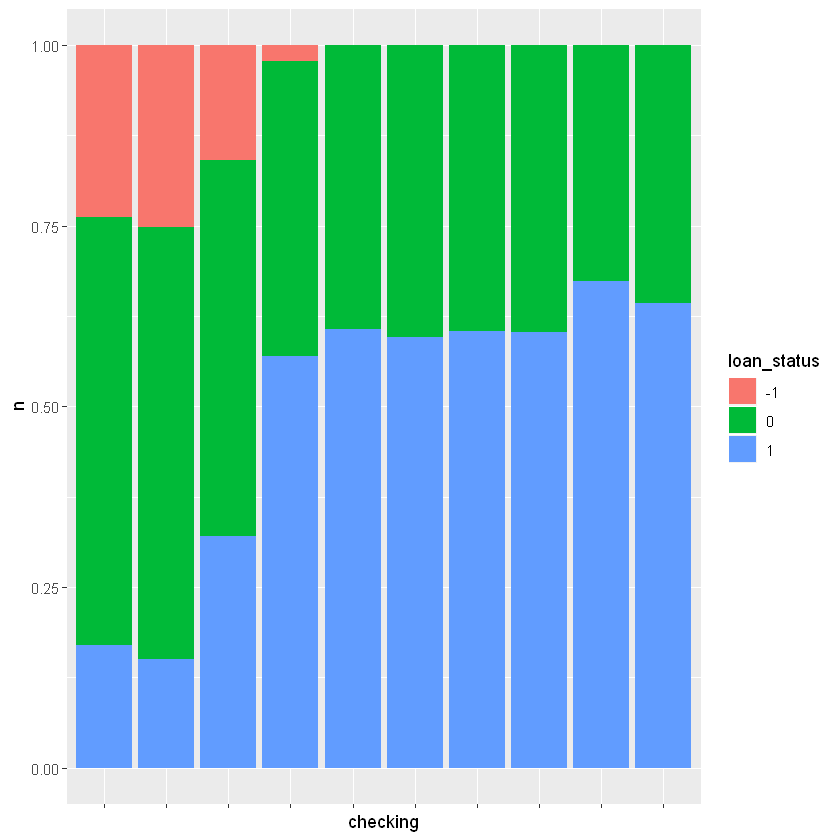

In [26]:
loan_1 %>% group_by(saving = cut_interval(saving_amount, 10), loan_status) %>% 
  count() %>% ggplot(aes(x = saving)) + 
  geom_bar(aes(y = n, fill = as.factor(loan_status)), stat = "identity", position = "fill") +
  scale_fill_discrete(name = "loan_status") + theme(axis.text.x = element_blank())

loan_1 %>% group_by(checking = cut_interval(checking_amount, 10), loan_status) %>% 
  count() %>% ggplot(aes(x = checking)) + 
  geom_bar(aes(y = n, fill = as.factor(loan_status)), stat = "identity", position = "fill") +
  scale_fill_discrete(name = "loan_status") + theme(axis.text.x = element_blank())

is_employed has the same information of yearly_salary variable with whether its value equals 0, so is_employed will be dropped.

In [27]:
table(loan_1$is_employed)
table(loan_1$yearly_salary[!loan_1$is_employed] == 0)


    0     1 
34508 66592 


 TRUE 
34508 

yearly_salary is cut into 10 groups, and the plot clearly shows the effect. yearly_salary will stay.

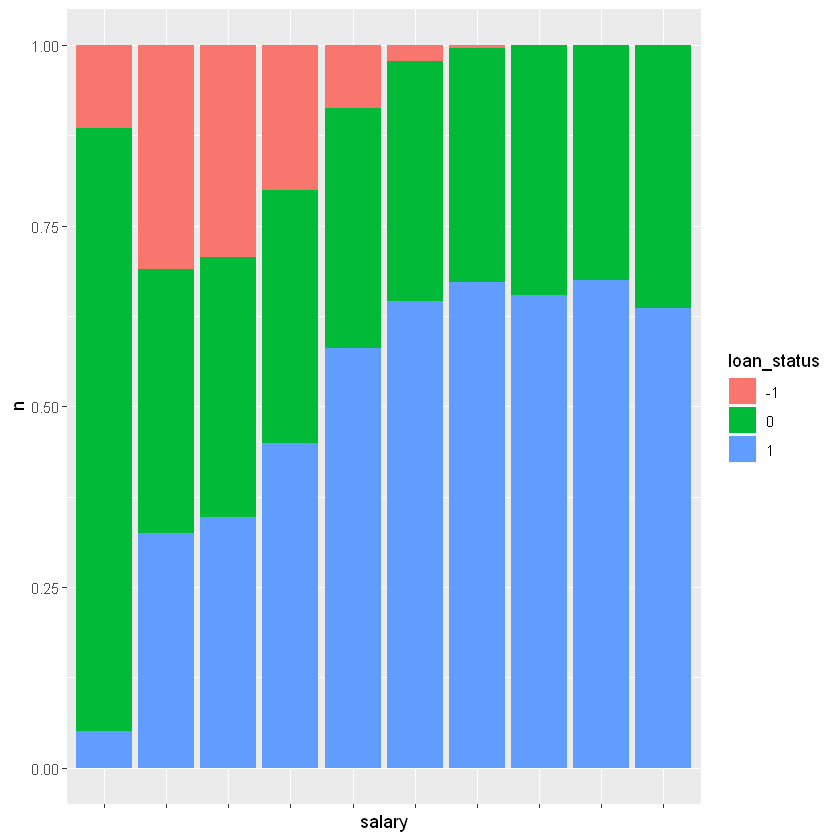

In [29]:
loan_1 %>% group_by(salary = cut_interval(yearly_salary, 10), loan_status) %>% 
  count() %>% ggplot(aes(x = salary)) + 
  geom_bar(aes(y = n, fill = as.factor(loan_status)), stat = "identity", position = "fill") +
  scale_fill_discrete(name = "loan_status") + theme(axis.text.x = element_blank())

age is cut into 10 groups, but the proportions of loan_status are very constant across age groups. age will be dropped.

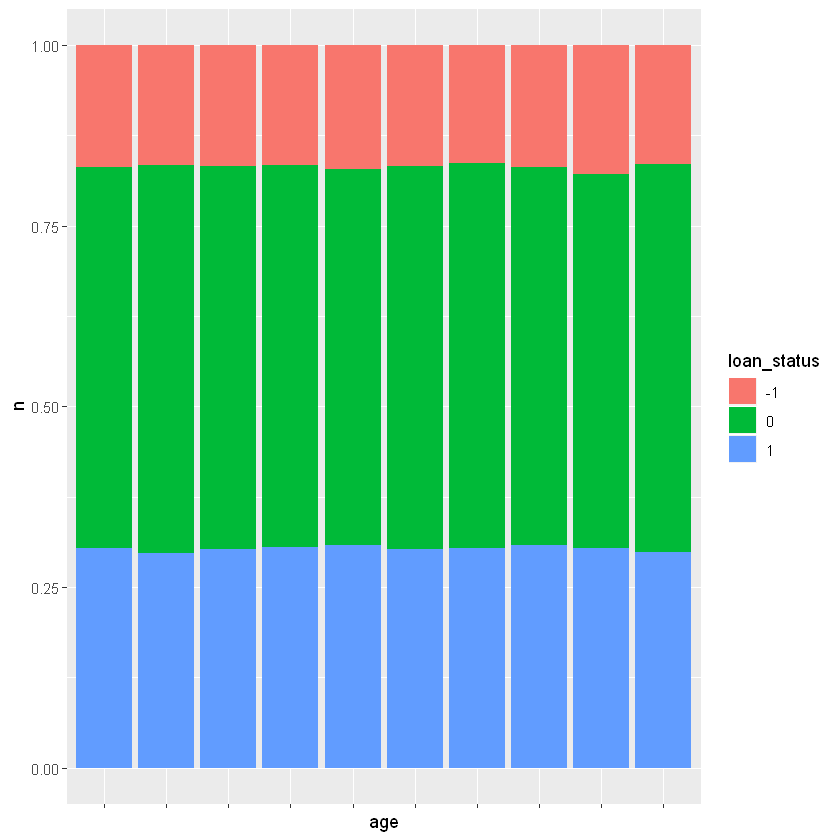

In [31]:
loan_1 %>% group_by(age = cut_interval(age, 10), loan_status) %>% 
  count() %>% ggplot(aes(x = age)) + 
  geom_bar(aes(y = n, fill = as.factor(loan_status)), stat = "identity", position = "fill") +
  scale_fill_discrete(name = "loan_status") + theme(axis.text.x = element_blank())

dependent_number shows loan_status changes with different numbers of dependents. So dependent_number will be kept.

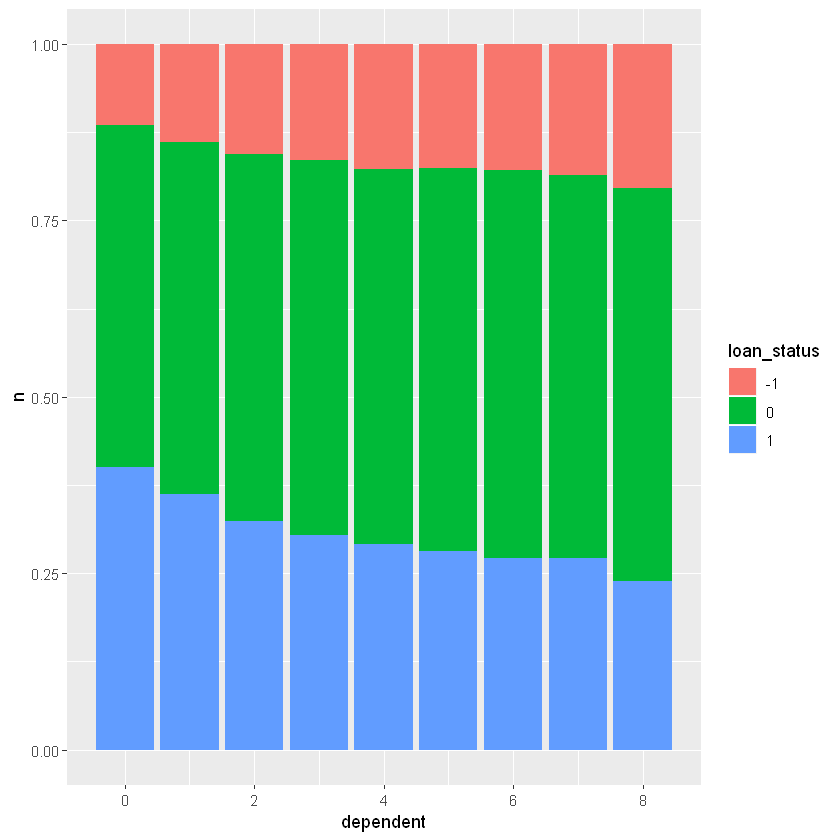

In [32]:
loan_1 %>% group_by(dependent = dependent_number, loan_status) %>% 
  count() %>% ggplot(aes(x = dependent)) + 
  geom_bar(aes(y = n, fill = as.factor(loan_status)), stat = "identity", position = "fill") +
  scale_fill_discrete(name = "loan_status")

In sum, 8 variables: loan_purpose, currently_repaying_other_loans,  total_credit_card_limit, avg_percentage_credit_card_limit_used_last_year,saving_amount,checking_amount,yearly_salary,dependent_number were selected as explanary variables.

loan_status is the response variable.

In [33]:
loan_2 <- loan_1 %>% select(loan_purpose, currently_repaying_other_loans,
                            total_credit_card_limit, 
                            avg_percentage_credit_card_limit_used_last_year,
                            saving_amount,
                            checking_amount,
                            yearly_salary,
                            dependent_number,
                            loan_status)
str(loan_2)

'data.frame':	101100 obs. of  9 variables:
 $ loan_purpose                                   : Factor w/ 5 levels "business","emergency_funds",..: 4 4 5 5 1 5 1 2 4 1 ...
 $ currently_repaying_other_loans                 : Factor w/ 3 levels "0","1","2": 3 3 3 1 3 3 1 2 1 2 ...
 $ total_credit_card_limit                        : int  8600 5300 0 5400 2900 3000 7800 4300 3900 1000 ...
 $ avg_percentage_credit_card_limit_used_last_year: num  0.79 0.52 2 0.52 0.76 0.82 0.3 1.02 0.65 1.09 ...
 $ saving_amount                                  : int  1491 141 660 3345 1050 1028 4206 886 1837 134 ...
 $ checking_amount                                : int  6285 5793 3232 2764 3695 3269 4368 1597 3795 1408 ...
 $ yearly_salary                                  : int  45200 0 26500 15800 34800 0 51100 15000 12000 0 ...
 $ dependent_number                               : int  7 5 4 4 4 3 2 2 1 2 ...
 $ loan_status                                    : num  0 0 0 1 -1 0 1 -1 1 0 ...


Save the loan_2 data frame.

In [ ]:
save(loan_2, file = "loan_2.Rda")

Check the numeric variables to see whether they linearly correlated to each other. total_credit_card_limit and avg_percentage_credit_card_limit_used_last_year showed a negative correlation of -0.49, saveing_amount and checking_amount showed a positive correlation of 0.2. They are both in the acceptable range. So all variables will be kept.

,total_credit_card_limit,avg_percentage_credit_card_limit_used_last_year,saving_amount,checking_amount,yearly_salary
total_credit_card_limit,1.0000000,-0.4990971,0.2341807,0.2409263,0.2224966
avg_percentage_credit_card_limit_used_last_year,-0.4990971,1.0000000,-0.1435317,-0.1467987,-0.1364382
saving_amount,0.2341807,-0.1435317,1.0000000,0.3010412,0.2887115
checking_amount,0.2409263,-0.1467987,0.3010412,1.0000000,0.2829085
yearly_salary,0.2224966,-0.1364382,0.2887115,0.2829085,1.0000000


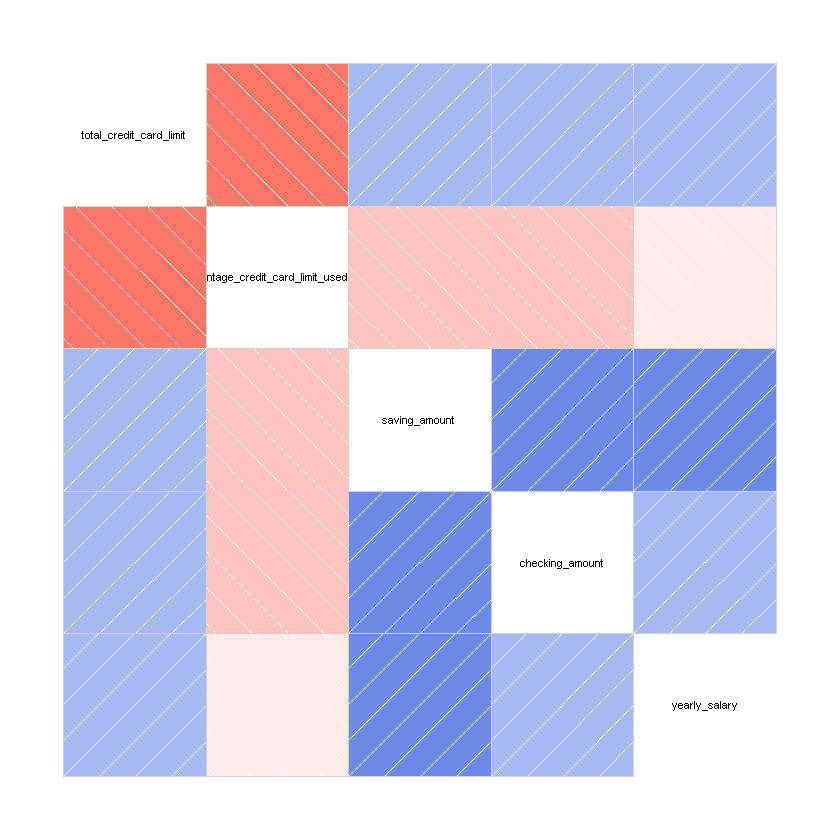

In [54]:
suppressWarnings(library(corrgram))
corrgram(loan_2[, c(3:7)])
cor(loan_2[, c(3:7)])

#### 3. *Model fitting and tuning*

To save time, 10% of the data was used. 

In [35]:
small_sample <- sample(1:dim(loan_2)[1], dim(loan_2)[1] * 0.1)
loan_3 <- loan_2[small_sample,]

Make loan_status vriable into a factor variable.

In [59]:
loan_3$loan_status <- factor(loan_3$loan_status, levels = c(-1, 0, 1))

Save the loan_3 data frame.

In [ ]:
save(loan_3, file = "loan_3.Rda")

The data frame loan_3 was divided into train and test sets in 75% to 25% ratio.

In [61]:
suppressWarnings(library(caret))
train_index <- createDataPartition(loan_3$loan_status, p = 0.75, list = F)
loan_3_train <- loan_3[train_index,]
loan_3_test <- loan_3[-train_index,]

This is a multi-class classification problem, tree and random forest models will be used.

* ***Fit tree model***

In [52]:
suppressWarnings(library(rpart))
model_tree <- rpart(loan_status ~ ., data = loan_3_train, method = "class")
pred_tree_test <- predict(model_tree, newdata = loan_3_test, type = "class")
pred_tree_train <- predict(model_tree, type = "class")

Make 2 functions to calculate train and test accuracy.

In [38]:
accuracy.train <- function(x) {
  t <- table(loan_3_train$loan_status, x)
  sum(diag(t)) / sum(t)
}

accuracy.test <- function(x) {
  t <- table(loan_3_test$loan_status, x)
  sum(diag(t)) / sum(t)
}

The accuracy for train set is 73.0%, and the accuracy for test is 73.6%.

In [39]:
accuracy.test(pred_tree_test)
accuracy.train(pred_tree_train)

[1] 0.7359462

[1] 0.7295622

Plot the tree.

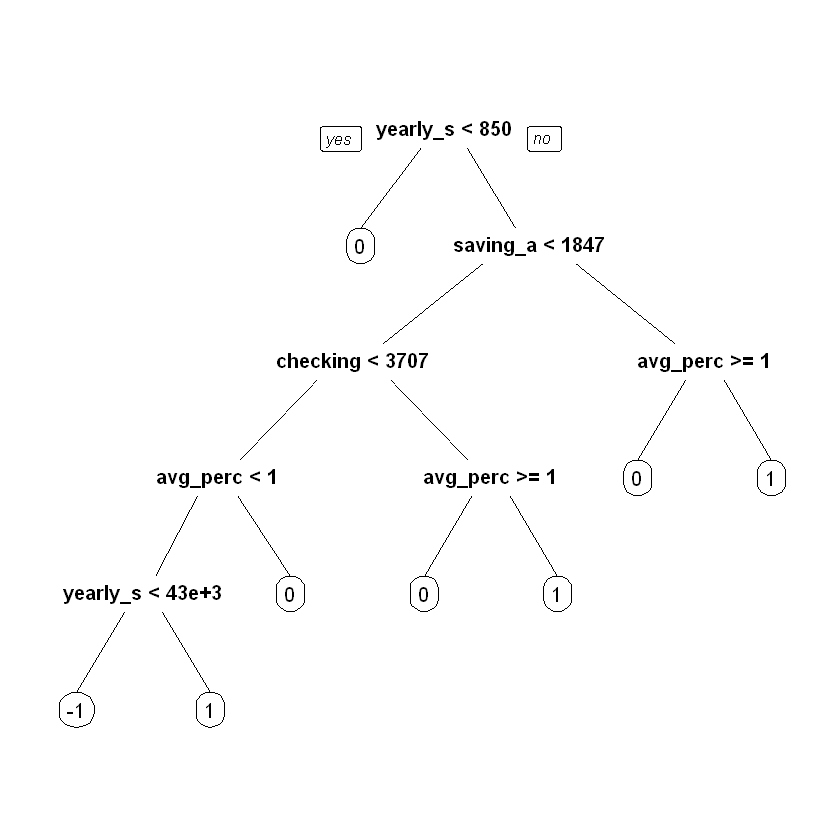

In [51]:
suppressWarnings(library(rpart.plot))
prp(model_tree)

Variable importance, yearly_salary is the most important feature, followed by saving_amount, checking account, avg_percentage_credit_card_limit_used_last_year, total_credit_card_limit, and currently_repaying_other_loans.

loan_purpose and dependent_number are not picked.

In [41]:
model_tree$variable.importance

yearly_salary 
                                      871.51391 
                                  saving_amount 
                                      282.83698 
                                checking_amount 
                                      281.77984 
avg_percentage_credit_card_limit_used_last_year 
                                      269.72728 
                        total_credit_card_limit 
                                      168.40031 
                 currently_repaying_other_loans 
                                       13.00125

* *Tree model tuning*

Find the cp values and try to prune the tree with different cp. The best result is cp = 0.01, the train accuracy is 73.0%, the test accuracy is 73.6%.

In [45]:
cp <- as.numeric(format(model_tree$cptable[,1], digits = 3))
model_tree_prune <- list()
for (i in cp) {
  tree_prune <- prune(model_tree, cp = i)
  key <- toString(i)
  model_tree_prune[[key]] <- tree_prune
}

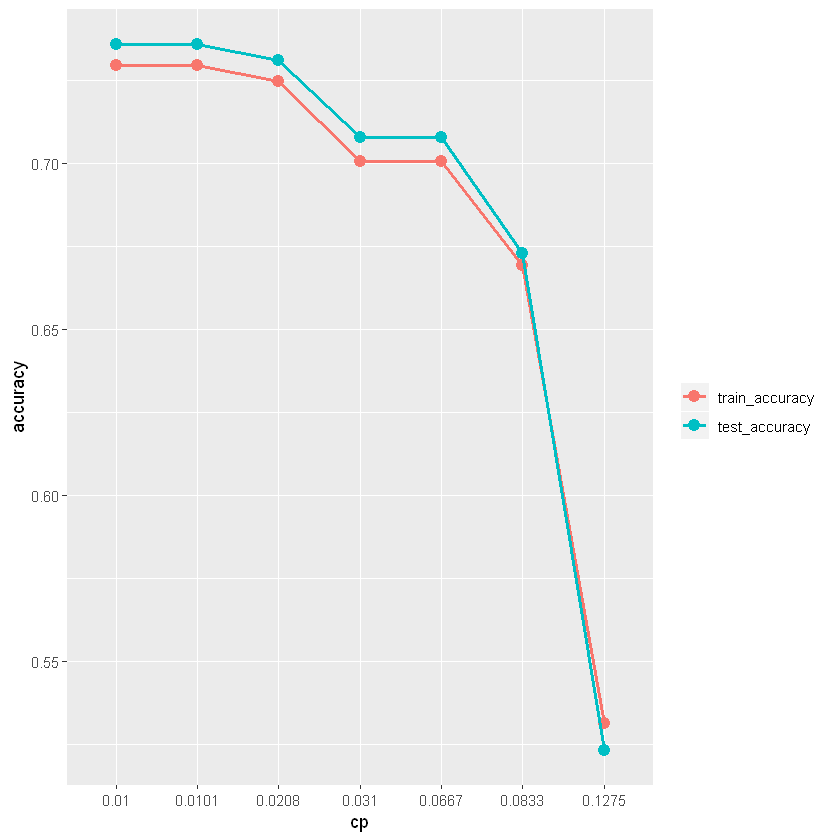

In [49]:
library(reshape2)
train_accuracy <- map_dbl(model_tree_prune, function(x) {
  pred_train <- predict(x, type = "class")
  accuracy.train(pred_train)
})
test_accuracy <- map_dbl(model_tree_prune, function(x) {
  pred_test <- predict(x, loan_3_test,type = "class")
  accuracy.test(pred_test)
})
model_prune_accuracy <- data.frame(train_accuracy, test_accuracy)
model_prune_accuracy %>% mutate(cp = row.names(.)) %>% melt(id.vars = "cp") %>% 
  ggplot(aes(x = cp, y = value, color = variable)) + geom_point(size = 3) + 
  geom_line(aes(group = variable), size = 1) +
  scale_color_discrete(name = "") + ylab("accuracy")

* ***Fit random forest model***

In [62]:
suppressWarnings(library(randomForest))
model_rf <- randomForest(loan_status ~ ., data = loan_3_train, importance = T)
pred_rf_train <- predict(model_rf)
pred_rf_test <- predict(model_rf, loan_3_test)
accuracy.train(pred_rf_train)
accuracy.test(pred_rf_test)

[1] 0.7260021

[1] 0.7371338

The accuracy values for train and test are 72.6% and 73.7%. It it almost the same as the tree model.

The variable importance order is yearly_salary, avg_percentage_credit_card_limit_used_last_year, saving_amount, checking_amount, total_credit_card_limit, loan_purpose, dependent_number, currently_repaying_other_loans

In [63]:
sort(model_rf$importanceSD[,"MeanDecreaseAccuracy"], decreasing = T)

yearly_salary 
                                   0.0005334846 
avg_percentage_credit_card_limit_used_last_year 
                                   0.0004763865 
                                  saving_amount 
                                   0.0004530803 
                                checking_amount 
                                   0.0004374590 
                        total_credit_card_limit 
                                   0.0004357942 
                                   loan_purpose 
                                   0.0003043642 
                               dependent_number 
                                   0.0002916219 
                 currently_repaying_other_loans 
                                   0.0002763474

* *Tune random forest model*

Number of variables tried at each split is tuned for 1 to 4. When number of variables tried at each split is 2, the performance is best.

The train accuracy is 72.9%, the test accuracy is 73.6%.

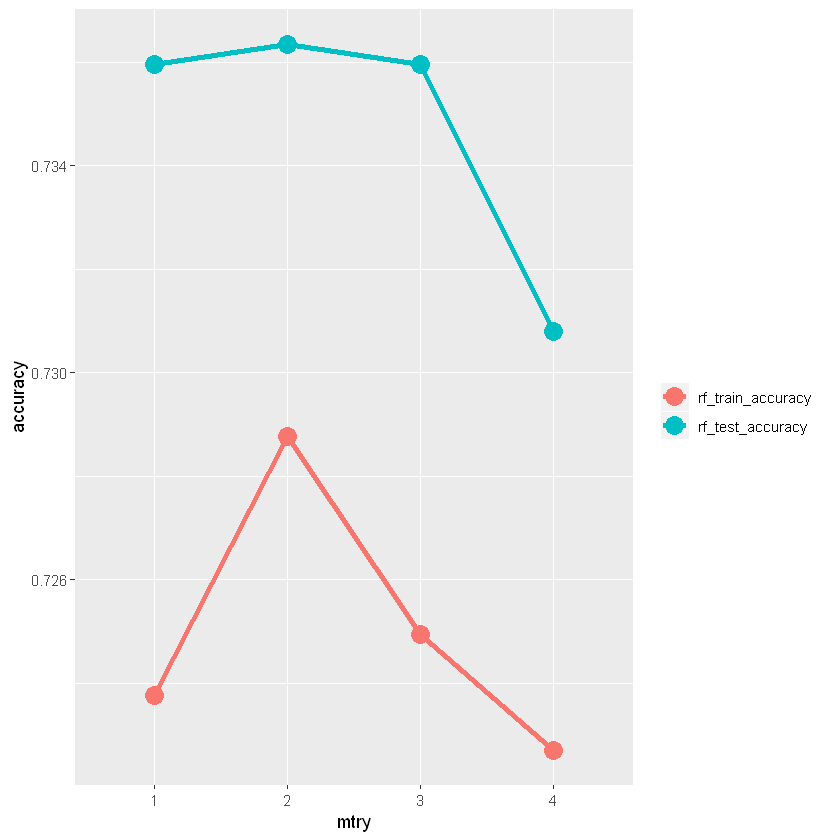

In [65]:
model_rf_mtry <- list()
for (i in 1:4) {
  rf_mtry <- randomForest(loan_status ~ ., mtry = i, data = loan_3_train, importance = T)
  key <- toString(i)
  model_rf_mtry[[key]] <- rf_mtry
}
rf_train_accuracy <- map_dbl(model_rf_mtry, function(x) {
  pred_train <- predict(x)
  accuracy.train(pred_train)
})
rf_test_accuracy <- map_dbl(model_rf_mtry, function(x) {
  pred_test <- predict(x, loan_3_test,type = "class")
  accuracy.test(pred_test)
})
model_rf_mtry_accuracy <- data.frame(rf_train_accuracy, rf_test_accuracy)

model_rf_mtry_accuracy %>% mutate(mtry = row.names(.)) %>% melt(id.vars = "mtry") %>% 
  ggplot(aes(x = mtry, y = value, color = variable)) + geom_point(size = 5) + 
  geom_line(aes(group = variable), size = 1.5) +
  scale_color_discrete(name = "") + ylab("accuracy")

mtry is set as 2, number of trees are tuned in 250, 500, 750, 1000. When number of trees is 500, test and train are both performing well.

The trian accuracy is 72.6%, the test accuracy is 73.6%.

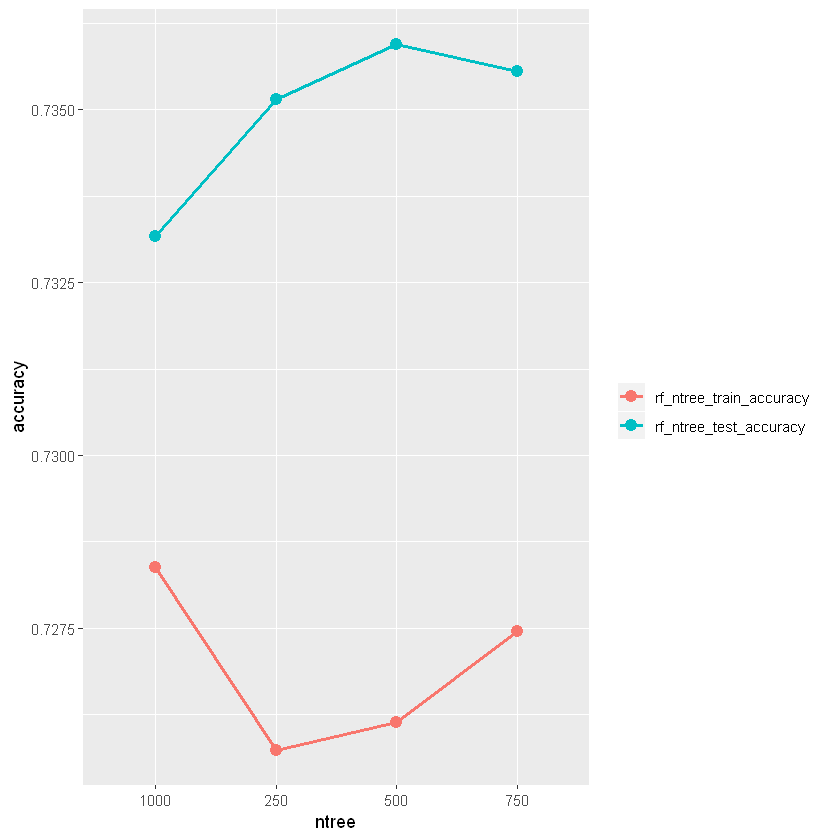

In [67]:
model_rf_ntree <- list()

for (ntree in c(250, 500, 750, 1000)) {
  rf_ntree <- randomForest(loan_status ~ ., mtry = 2, ntree = ntree, data = loan_3_train, importance = T)
  key <- toString(ntree)
  model_rf_ntree[[key]] <- rf_ntree
}

rf_ntree_train_accuracy <- map_dbl(model_rf_ntree, function(x) {
  pred_train <- predict(x)
  accuracy.train(pred_train)
})

rf_ntree_test_accuracy <- map_dbl(model_rf_ntree, function(x) {
  pred_test <- predict(x, loan_3_test,type = "class")
  accuracy.test(pred_test)
})

model_rf_ntree_accuracy <- data.frame(rf_ntree_train_accuracy, rf_ntree_test_accuracy)
model_rf_ntree_accuracy %>% mutate(ntree = row.names(.)) %>% melt(id.vars = "ntree") %>% 
  ggplot(aes(x = ntree, y = value, color = variable)) + geom_point(size = 3) + 
  geom_line(aes(group = variable), size = 1) +
  scale_color_discrete(name = "") + ylab("accuracy")

#### 4. *Conclusions*

1. The raw data contain much unuseful and redundant information, so the data was cleaned and some of its features were dropped. A new response variable was created as 3-class factor, together with other new explanary variables created from raw data. Some NA values are properly patched with reasonable assumptions. Finally, 8 features were determined for the next model training.

2. Two models, tree and random forest, were used to fit the data. Both gave similar train and test accuracies (73% - 74%). Since tree is simple and easy to explain, it was used to make a web application using shiny apps.

3. Both models indicate that the 4 more important features are yearly salary, saving amount, checking amount, and total credit card limit. This inference can be well understood by common sense. The yearly salary represents the borrower's capacity of gaining enough financial sources, so it is the most important featue in the loan application. Both saving and checking amounts indicate the borrower's ability of paying debts. And the total credit card limit gives insight into how much other financial institutes can trust the borrower.

4. The tree model was tuned with various cp values. When cp is 0.01, the pruned tree gave the best performance. Since the tree is not complex, unpruned tree is picked as the final model.

5. The random forest model was tuned with number of variables selected for each try and number of trees. When number of variables selected for each try is 2 and the number of trees is 500, the model performs the best.

6. This loan challenge problem contains information about the loan and the borrower. If more information is provided, the model will be improved. For example, loan amount, debt to income ratio, original interest rate, current interest rate, loan term, etc.